<a href="https://colab.research.google.com/github/dlskawns/cp1/blob/main/Project_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트 주제: 

#### 딥러닝을 이용한 리뷰기반 고객탐색 및 추천 알고리즘

<br>

딥러닝 모델을 통해 이커머스 데이터의 마케팅적 분석을 진행하고 리뷰를 분석하여, 문제요소를 찾아 개선하고 이를 바탕으로 고객을 세분화하여 타겟에 더욱 적합한 추천시스템을 적용하는 것을 목표로 합니다.


### 필요 모듈 가져오기 

In [ ]:
!pip install squarify
!pip install transformers
!pip install category_encoders
!pip install sentence-transformers

In [ ]:
from google.colab import drive
from imblearn.over_sampling import BorderlineSMOTE
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TFBertModel, BertConfig, BertTokenizer
import tensorflow as tf
from tensorflow.keras.layers import Dropout
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings(action='ignore')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


True

### 데이터 불러오기

* 구글 드라이브의 폴더 및 파일을 접근하기 위해 마운트 합니다.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/reviews_project2.csv')
df.rename(columns={'Summary ':'Summary'}, inplace=True)

In [ ]:
df['Summary'].fillna('', inplace=True)

In [ ]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/Reviews.csv')
df.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


## 1. EDA 및 특성공학

각 Features의 특징을 면밀히 체크합니다.

특히 Funnel 분석을 위해선 최종적으로 재구매 주기 및 재구매가 줄어든 시점을 파악해봅니다.

In [ ]:
# 수치 데이터 파악
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [ ]:
#결측치 확인
df.isnull().sum()

Id                             0
ProductId                      0
UserId                         0
ProfileName                   16
HelpfulnessNumerator           0
HelpfulnessDenominator         0
Score                          0
Time                           0
Summary                       27
Text                           0
date                           0
dayofweek                      0
r_counts                       0
keyword                        0
labels                    475716
pet                            0
dtype: int64

In [ ]:
# 요약부분 결측치 str 구조로 대체
df['Summary'].fillna('', inplace = True)

df['ProfileName'].fillna('', inplace = True)

---

특성 생성 1. 

타임스탬프 데이터를 통해 리뷰 작성 날짜 인사이트를 파악해봅니다.

해당 날짜를 'date' feature를 생성해 샘플별로 저장합니다.

* 날짜를 통해 고객의 재구매까지 걸리는 기간을 파악 가능
* 날짜 별 분포를 통해 고객 리뷰의 날짜별 패턴 유무 파악 가능

In [ ]:
# 날짜를 변경
df['date'] = pd.to_datetime(df['Time'], unit = 's')
df

---

특성 생성 2.

해당 datetime 형식의 'date' feature에서 더 나아가 요일 데이터를 파악해 feature로 만들어 봅니다.

calendar 모듈을 이용해 변경 및 'dayofweek' feature를 생성 및 저장합니다.

* 요일 별 고객 구매행동의 패턴 유무를 파악합니다.

In [ ]:
import calendar

# 요일 특성 생성

df['dayofweek'] = df['date'].map(lambda x: calendar.day_name[x.weekday()])


---

#### 요일 및 별 리뷰 수 분포 

* 주말에 리뷰가 적고 평일에 리뷰 수가 많음.

* 날짜 별 분포로는 전체 중 2012년도에 데이터가 가장 많음  
특별히 더 얻을 정보는 없어 보임

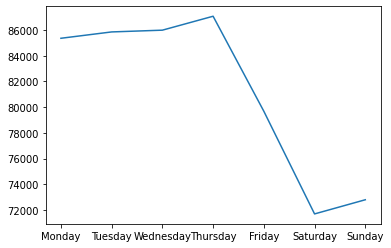

In [ ]:
# 요일 별 리뷰 수 분포
c = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.plot(df['dayofweek'].value_counts().reindex(c).index, df['dayofweek'].value_counts().reindex(c).values);

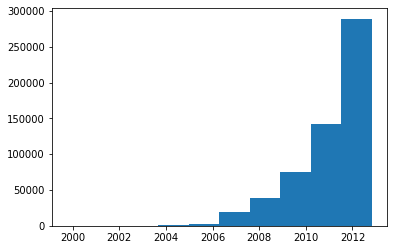

In [ ]:
# 날짜 별 리뷰 수 분포
# plt.bar(df['date'].value_counts().index, df['date'].value_counts().values);
plt.hist(df['date']);
plt.show()

---

특성 생성 3. 

유저 별 리뷰 수를 나타내는 feature를 생성합니다.

* Unique한 UserId 당 몇 개의 샘플을 갖고 있는지 확인 가능  
이를 통해 충성고객 여부 또는 재구매 관련 분석 진행 가능

In [ ]:
# 유저별 리뷰 수 칼럼 생성
df_re = df['UserId'].value_counts().reset_index()
df_re.columns = ['UserId','r_counts']
df = df.join(df_re.set_index('UserId')['r_counts'], on='UserId')

---

#### 유저, 리뷰수, 평점 관계 분포

\* <small> 모든 고객이 상품 구매 후 100% 리뷰를 작성했다고 가정 (리뷰가 없는 데이터가 따로 없으므로)</small>


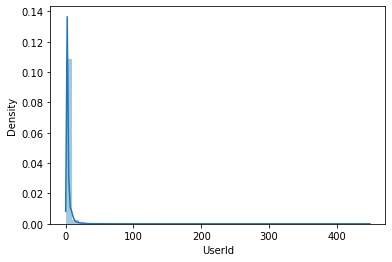

In [ ]:
# 유저 별 리뷰 수 분포
sns.distplot(df['UserId'].value_counts());

In [ ]:
# 리뷰수 구간 별 유저 수
print('리뷰 수 1: ',len(df[df['r_counts']==1]['UserId'].unique()))
print('리뷰 수 2~100: ',len(df[(df['r_counts']<=100) & (df['r_counts'] > 1)]['UserId'].unique()))
print('리뷰 수 100~: ',len(df[df['r_counts'] >= 1]['UserId'].unique()))


리뷰 수 1:  175391
리뷰 수 2~100:  80605
리뷰 수 100~:  256059


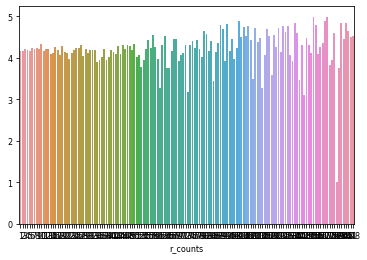

In [ ]:
# 리뷰수 별 평균 평점 > 리뷰를 조금 달았다고 꼭 스코어가 낮은 것은 아니다.

sns.barplot(df.groupby('r_counts')['Score'].mean().index, df.groupby('r_counts')['Score'].mean().values);

plt.show();

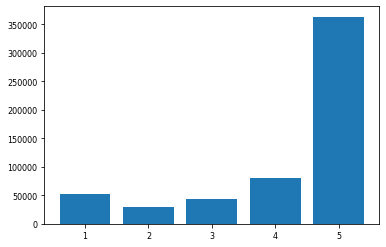

In [ ]:
# 스코어 분포 파악
plt.bar(df['Score'].value_counts().index, df['Score'].value_counts().values);


* 1~30개 정도의 리뷰를 쓴 유저가 가장 많음 >> 구매 불만족으로 인해 리뷰 수(재구매)가 적은 것인지 의문
* 리뷰 수 별 고객 평균 평점분포 확인 >> 리뷰 수가 적다고 평점이 낮지 않음. 고객 이탈과 연관짓기 어려움
* 전체 데이터의 점수 분포 파악 >> 5점이 압도적으로 많아 스코어를 통해 고객 이탈원인 파악이 쉽지 않음

---

#### 리뷰 TOP 10의 개수 및 평점 파악

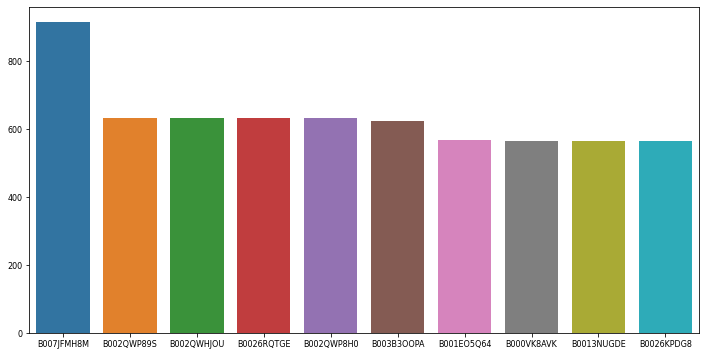

In [ ]:
# 리뷰가 가장 많은 상품 TOP 10 리뷰 개수
product_most = df['ProductId'].value_counts()[:10]
plt.figure(figsize=(12,6))

plt.rc('font', size=8)        # 기본 폰트 크기
sns.barplot(product_most.index, product_most.values);
plt.title('Reviews Top 10')
plt.show();

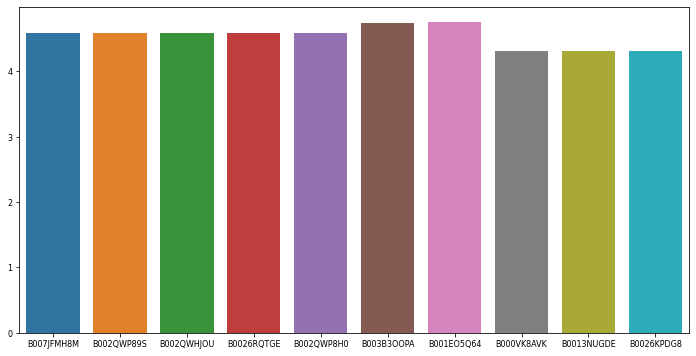

In [ ]:
# 리뷰수 top 10의 스코어 평균 파악
products10_score=[]
for i in range(len(product_most.index)):
  products10_score.append(round(df[df['ProductId']==(product_most.index)[i]]['Score'].mean(),2))
plt.figure(figsize=(12,6))
sns.barplot(product_most.index, products10_score);
plt.rc('font', size=8)        # 기본 폰트 크기
plt.show();

#### (3점 미만의) 리뷰 TOP 10의 개수 및 평점 파악

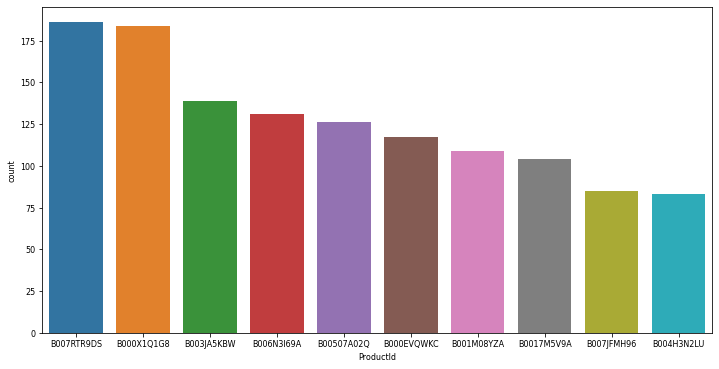

In [ ]:
# 평점이 낮은 상품(3미만)중 리뷰가 많은 상품 개수
plt.figure(figsize=(12,6))
sns.barplot(product_cnt_low_scored.index, product_cnt_low_scored['count']);
plt.rc('font', size=8)        # 기본 폰트 크기
plt.show();

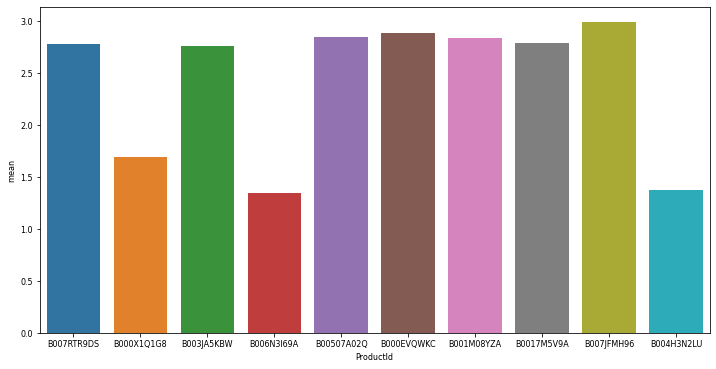

In [ ]:
# 평점이 낮은 상품(3미만)중 리뷰가 많은 상품 평점 평균
product_cnt_low_scored = df.groupby('ProductId')['Score'].agg(['count', 'mean']).sort_values(ascending=False, by= 'count' )
product_cnt_low_scored = product_cnt_low_scored[product_cnt_low_scored['mean']<3][:10]
plt.figure(figsize=(12,6))
sns.barplot(product_cnt_low_scored.index, product_cnt_low_scored['mean']);
plt.rc('font', size=8)        
plt.show();

* 5점을 준 케이스가 많아 TOP 10 상품의 리뷰수 자체가 3점 미만 TOP 10보다 약 4배이상 차이 발생.
* 평점 평균도 큰 의미가 없음

---

특성 생성 5. 

재구매까지 걸리는 기간을 체크합니다.  
같은 고객에 대한 샘플의 날짜 별 정렬을 통해 직전에 구매한 날짜로부터 리뷰작성 당시까지의 기간을 계산

* 고객의 구매 행태 등 관련 인사이트 도출 가능

In [ ]:

# 3. 이전 구매이후 재구매까지 걸린 기간 
day_list = []
df = df[df['r_counts']>1].sort_values(by = ['UserId', 'Time']).reset_index()
for i in range(len(df)):
  print(i)
  if i == 0:
    day_list.append(0)
  elif (df['UserId'][i] == df['UserId'][i-1]) & (df['date'][i] != df['date'][i-1]):
    k = df['date'][i] - df['date'][i-1]
    day_list.append(k.days)
  else:
    day_list.append(0)
df['day_reorder']= day_list

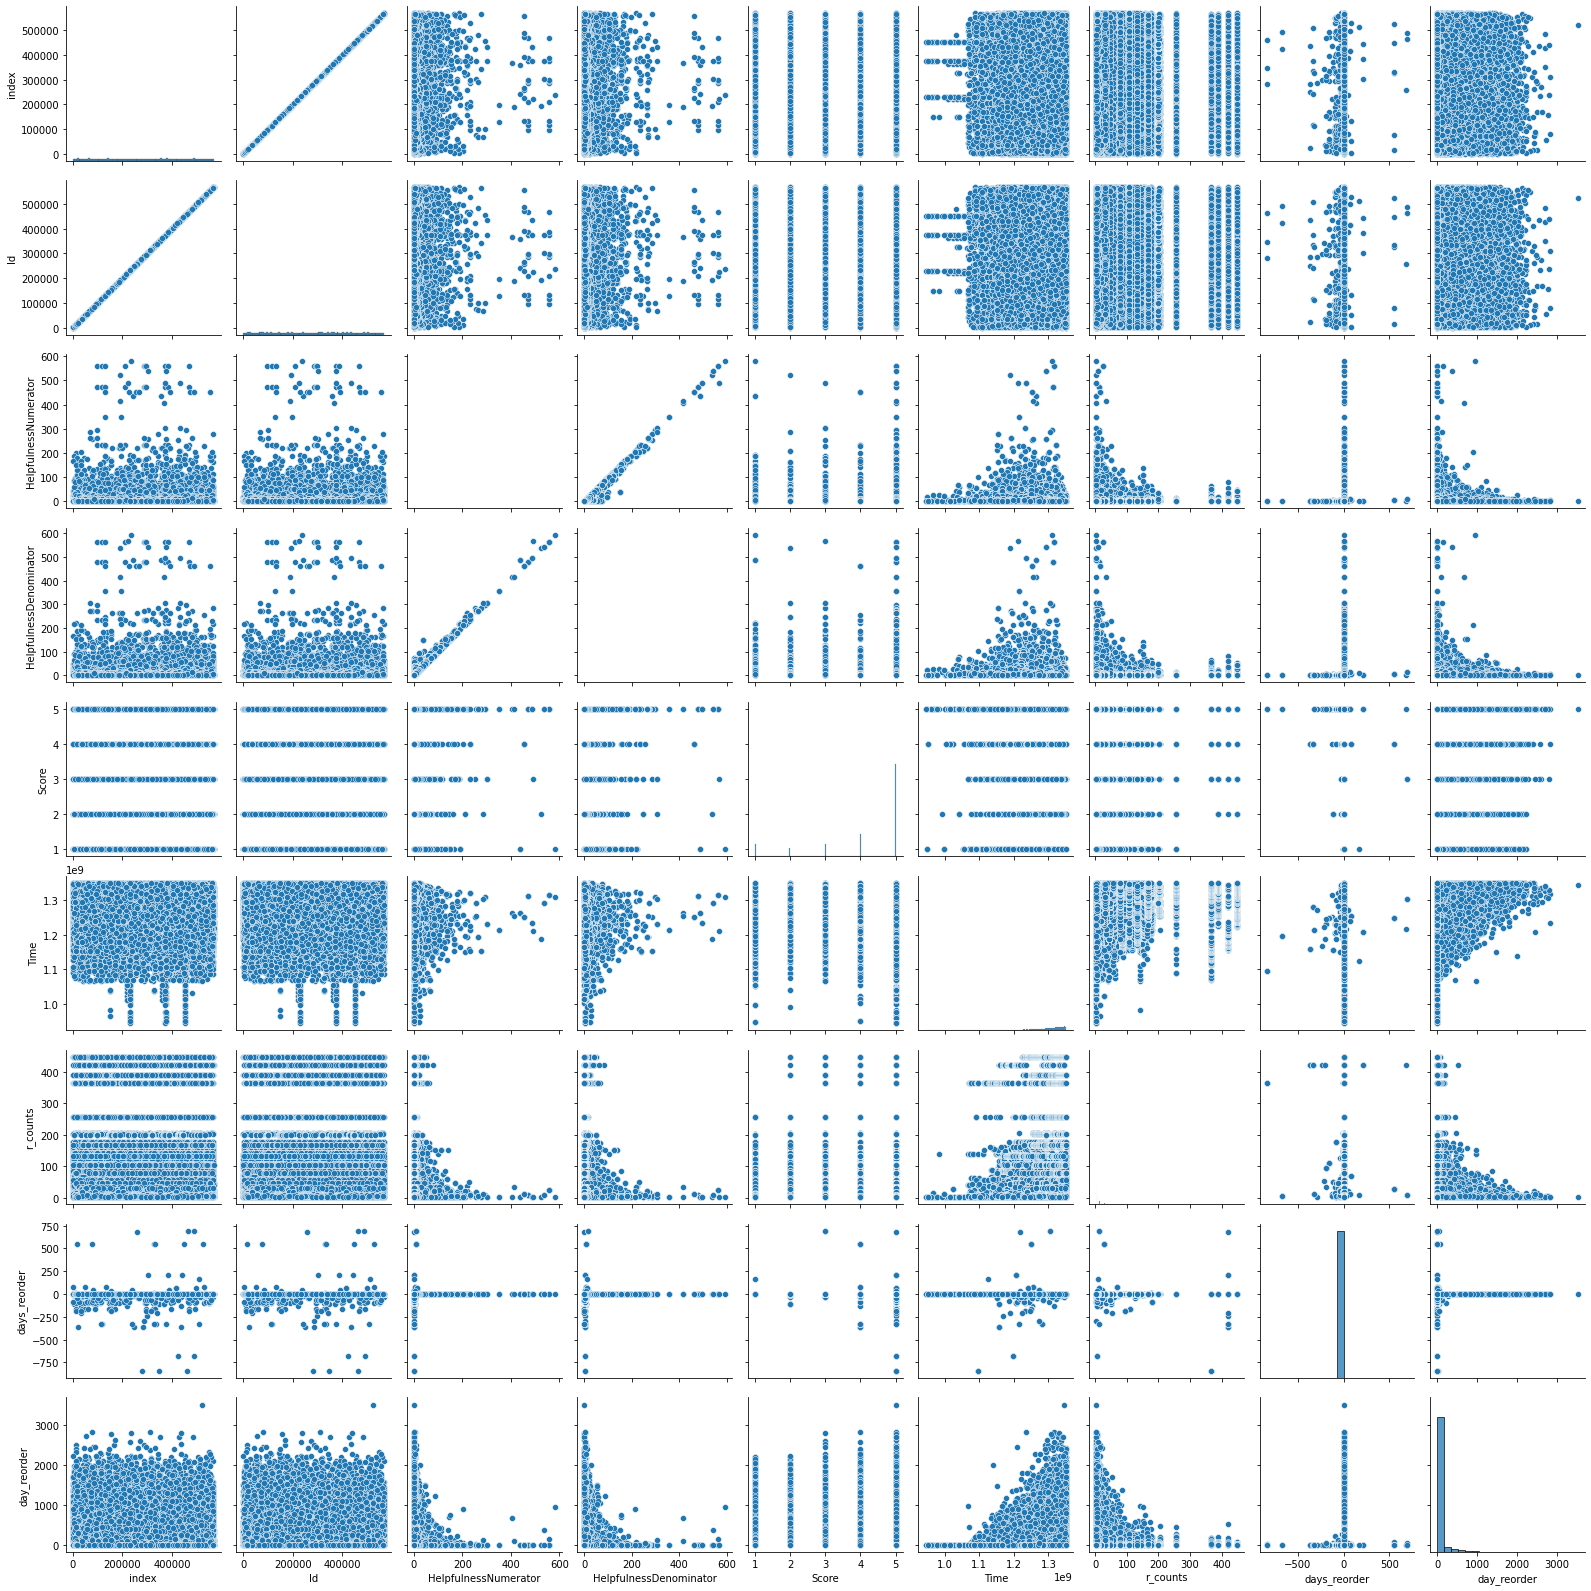

In [ ]:
# 페어플랏을 통해 전체 특성들의 상관관계 한눈에 파악
sns.pairplot(data= df)

* day_reorder(재구매까지의 기간)이 낮을 수록 r_counts(리뷰 개수)가 높다.
* day_reorder(재무개까지의 기간)이 낮을 수록 Helpfulness(리뷰 추천 수)가 높다.
> = r_counts(리뷰 개수)가 높은 사람의 리뷰일 수록 Helpfulness(리뷰 추천 수)가 높다.

리뷰 개수가 높은 사람의 리뷰는 신뢰성이 높은 내용일 가능성이 높으므로  
해당 고객의 상품 리뷰 및 평점, 추후에 생성할 키워드 등을 면밀이 분석해 문제의 원인을 찾거나 마케팅 요소를 발견할 수 있음  

---